In [122]:
install.packages('fGarch')

Installing package into ‘/Users/sarthakdasadia/Library/R/3.3/library’
(as ‘lib’ is unspecified)


In [2]:
options(warn=-1)

library(xts)
library(Quandl)
library(dplyr)
library(plotly)
library(lubridate)
library(forecast)
library(TSPred)
library(fGarch)
library(tseries)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘dplyr’

The following objects are masked from ‘package:xts’:

    first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: timeDate
Loading required package: timeSeries

Attaching package: ‘timeSeries’

The following object is masked from ‘package:zoo’:

    time<-

Loading required package: fBasics


Rmetrics Package 

### Dowload data using Quandl API

- The API will provide weekly data since 04/08/1990 
- It will form a dataframe which needs to be reversed to in chronological order

In [3]:
qurtly_data = Quandl("CHRIS/CME_NG1", collapse = 'quarterly')
monthly_data = Quandl("CHRIS/CME_NG1", collapse = 'monthly', start_date="2010-12-31")
daily_data = Quandl("CHRIS/CME_NG1", collapse = 'daily')

In [4]:
qurtly_data <- qurtly_data[rev(rownames(qurtly_data)),]
monthly_data <- monthly_data[rev(rownames(monthly_data)),]
daily_data <- daily_data[rev(rownames(daily_data)),]

In [5]:
head(monthly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
79,2010-12-31,4.325,4.454,4.306,4.405,NA,4.405,81995,168465
78,2011-01-31,4.323,4.460,4.290,4.420,NA,4.420,92454,253481
77,2011-02-28,4.009,4.100,3.954,4.037,NA,4.037,130789,219036
76,2011-03-31,4.374,4.442,4.205,4.389,NA,4.389,124477,248578
75,2011-04-30,4.570,4.705,4.555,4.698,NA,4.698,194267,158448
74,2011-05-31,4.560,4.707,4.525,4.666,NA,4.666,146465,216595


In [6]:
tail(monthly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
6,2017-01-31,3.224,3.235,3.110,3.133,0.115,3.117,174873,289649
5,2017-02-28,2.691,2.788,2.653,2.768,0.081,2.774,181547,274465
4,2017-03-31,3.199,3.242,3.163,3.192,0.001,3.190,112343,308378
3,2017-04-30,3.240,3.298,3.229,3.269,0.037,3.276,113998,269621
2,2017-05-31,3.146,3.172,3.061,3.080,0.074,3.071,200303,309712
1,2017-06-30,3.020,3.080,3.016,3.064,0.030,3.067,10609,7063


In [6]:
dim(qurtly_data)
dim(monthly_data)
dim(daily_data)

[1] 109   9

[1] 327   9

[1] 6828    9

In [134]:
p1 <- plot_ly(daily_data, x = ~Date, y = ~Open, type = 'scatter', mode = 'lines') %>%
        layout(title = "Natural Gas Prices Chart",
         xaxis = list(title = "Year"),
         yaxis = list (title = "Price in US$ per Million BTU"))
p1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Convert the dataframe into a time series and check properties

In [8]:
#qurtly_ts <- ts(qurtly_data$Open, frequency=4, start = decimal_date(ymd("1990-06-30")))
monthly_ts <- ts(monthly_data$Open, frequency=12, start = decimal_date(ymd("2010-12-31")))
daily_ts <- ts(log(daily_data$Open))

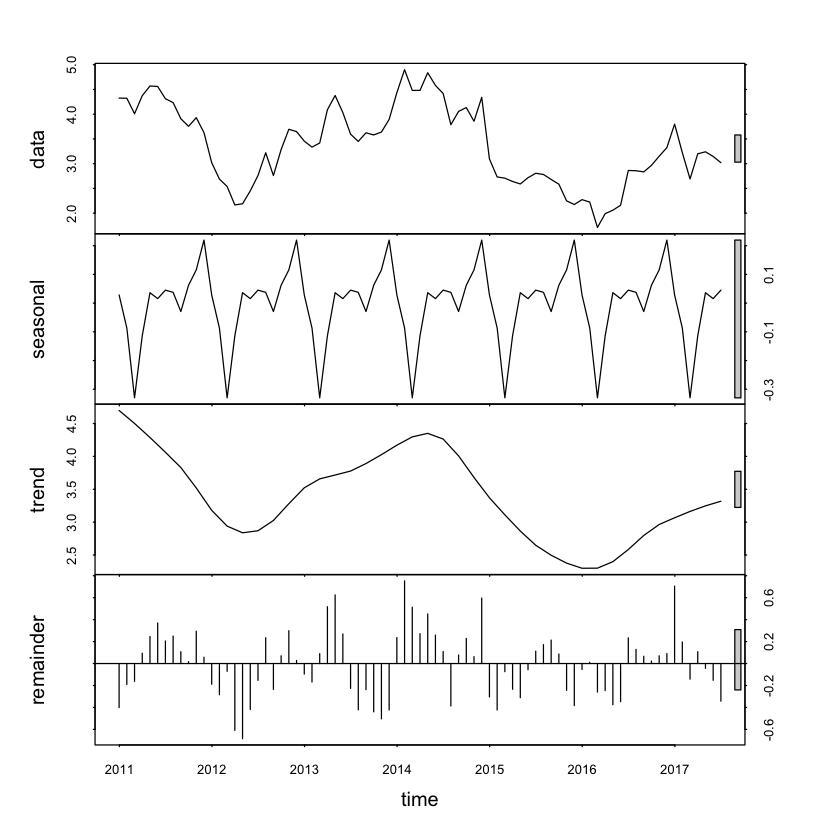

In [9]:
# Decompose time series

decomp = stl(monthly_ts, s.window="periodic")
plot(decomp)

We clearely see seasonality in the residual plot. For Time Series analysis, we need to convert it into a stationary series.

The ***augmented Dickey-Fuller (ADF)*** test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

In [10]:
adf.test(monthly_ts, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  monthly_ts
Dickey-Fuller = -2.1938, Lag order = 4, p-value = 0.4964
alternative hypothesis: stationary


This means that the series is not stationary. Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. 


	Augmented Dickey-Fuller Test

data:  monthly_dff1
Dickey-Fuller = -6.2289, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


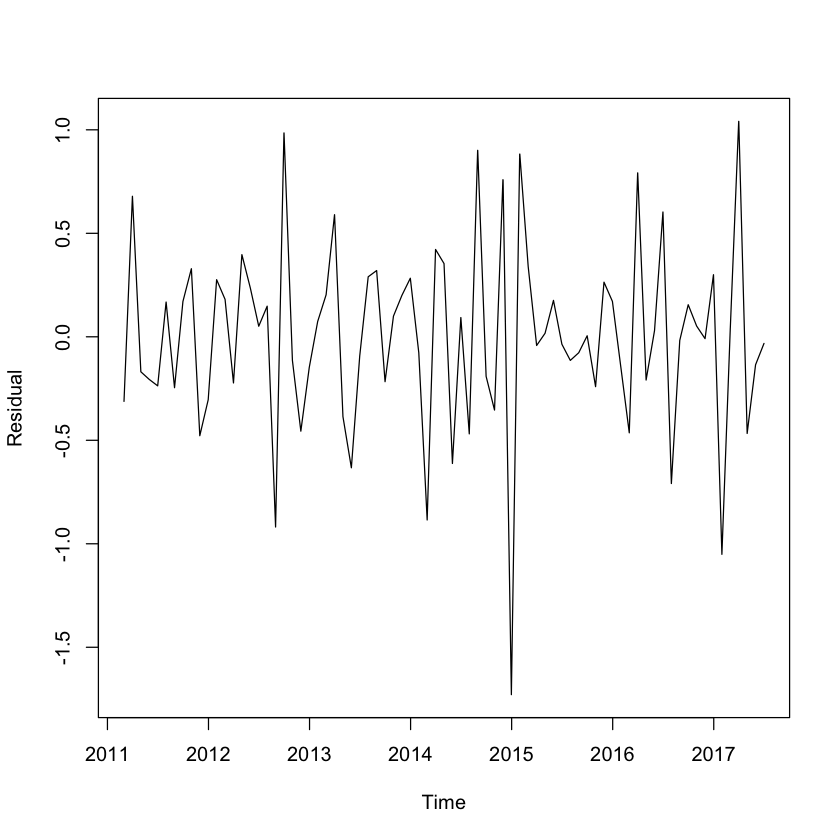

In [13]:
monthly_dff1 = diff(monthly_ts, differences = 2)
adf.test(monthly_dff1, alternative = "stationary")

plot(monthly_dff1, ylab="Residual")

In [14]:
summary(monthly_dff1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.72900 -0.22300  0.00500 -0.00161  0.26400  1.04100 

The mean is close to 0 and Dickey-Fuller Test suggests that the null hypothesis can be rejected. That is TS is close to being a stationary and differencing parameter ***d = 1***

*** Autocorrelations and Choosing Model Order ***

Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model. Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

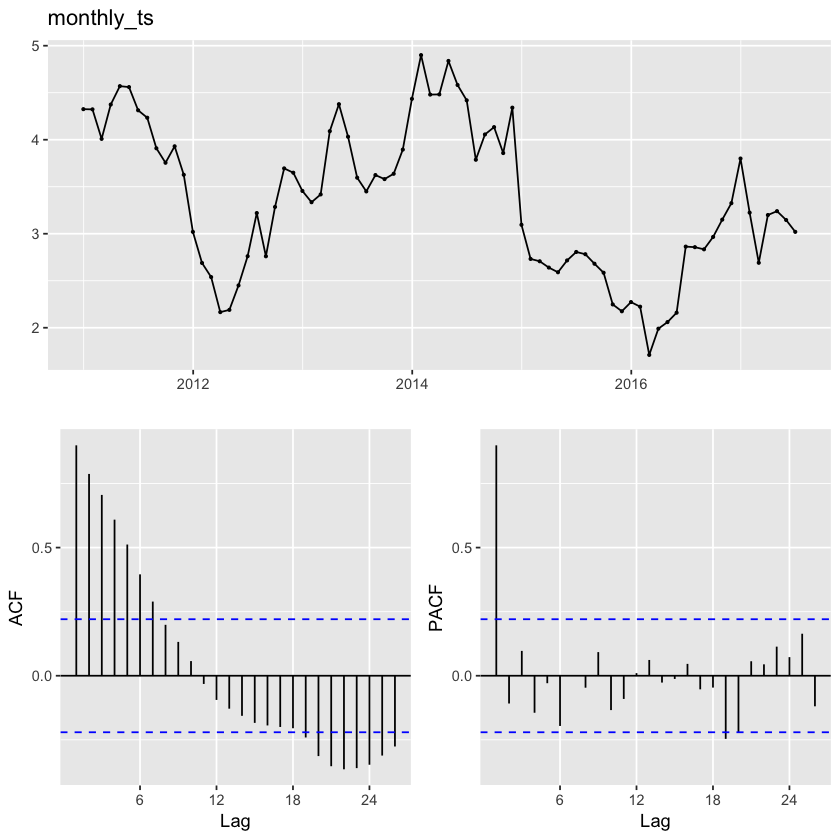

In [15]:
# Inspect ACF and PACF

ggtsdisplay(monthly_ts)

#### Auto-correlation of residual

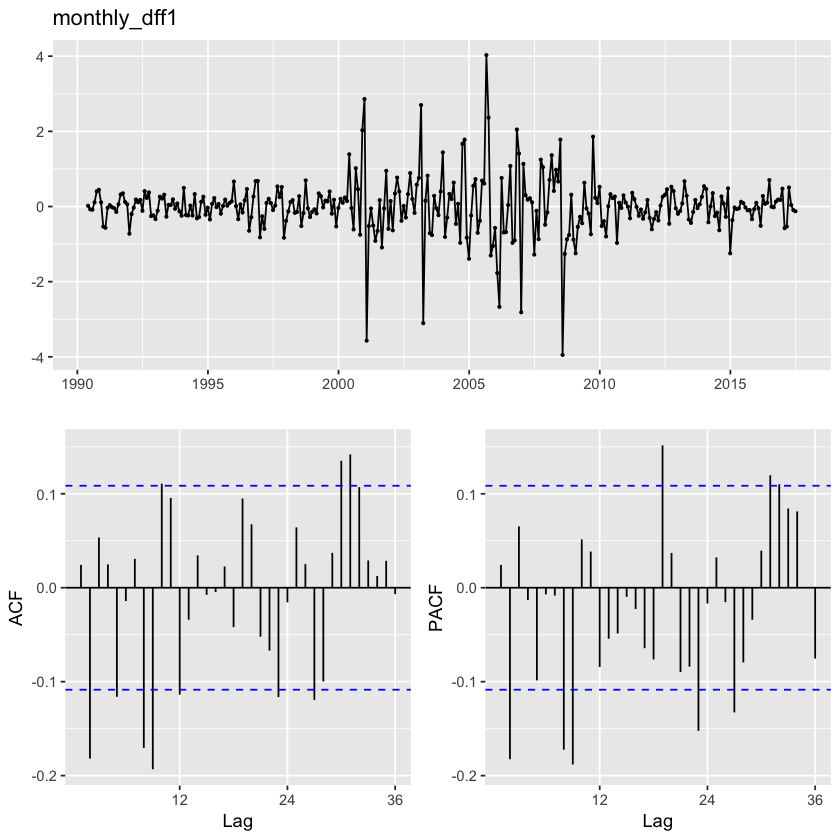

In [14]:
ggtsdisplay(monthly_dff1)

There are significant auto correlations at lag 2 and 9 and beyond. Partial correlation plots show a significant spike at lag 8 and 9. This suggests that we might want to test models with AR or MA components of order 2, 8, or 9. 


Call:
arima(x = monthly_ts, order = c(9, 2, 9))

Coefficients:
          ar1      ar2      ar3      ar4      ar5      ar6      ar7      ar8
      -0.6487  -0.7535  -0.2091  -0.1623  -0.1263  -0.4560  -0.4437  -0.7526
s.e.   0.1499   0.1721   0.2461   0.2723   0.2440   0.1946   0.1663   0.1253
         ar9      ma1      ma2      ma3      ma4     ma5     ma6     ma7
      0.0288  -0.1636  -0.0889  -0.4158  -0.2472  0.2467  0.4164  0.0888
s.e.  0.1471   0.1275   0.1313   0.1329   0.1249  0.1276  0.1311  0.1331
         ma8      ma9
      0.1640  -0.9988
s.e.  0.1285   0.1290

sigma^2 estimated as 0.07728:  log likelihood = -18.98,  aic = 75.96

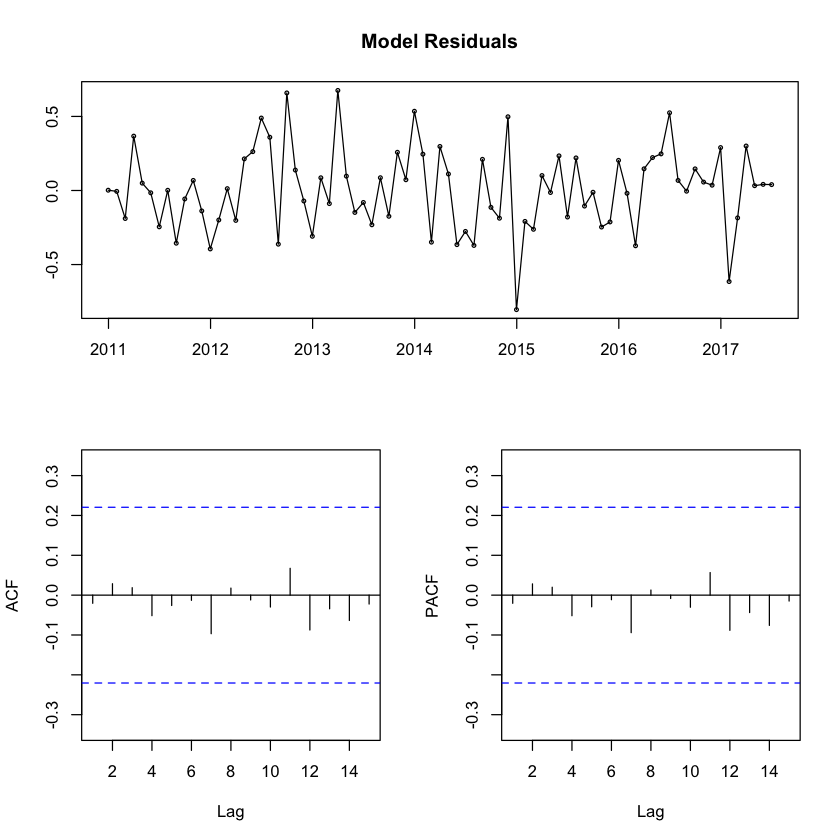

In [16]:
fit_monthly = arima(monthly_ts, order=c(9,2,9))
fit_monthly

tsdisplay(residuals(fit_monthly), lag.max=15, main='Model Residuals')

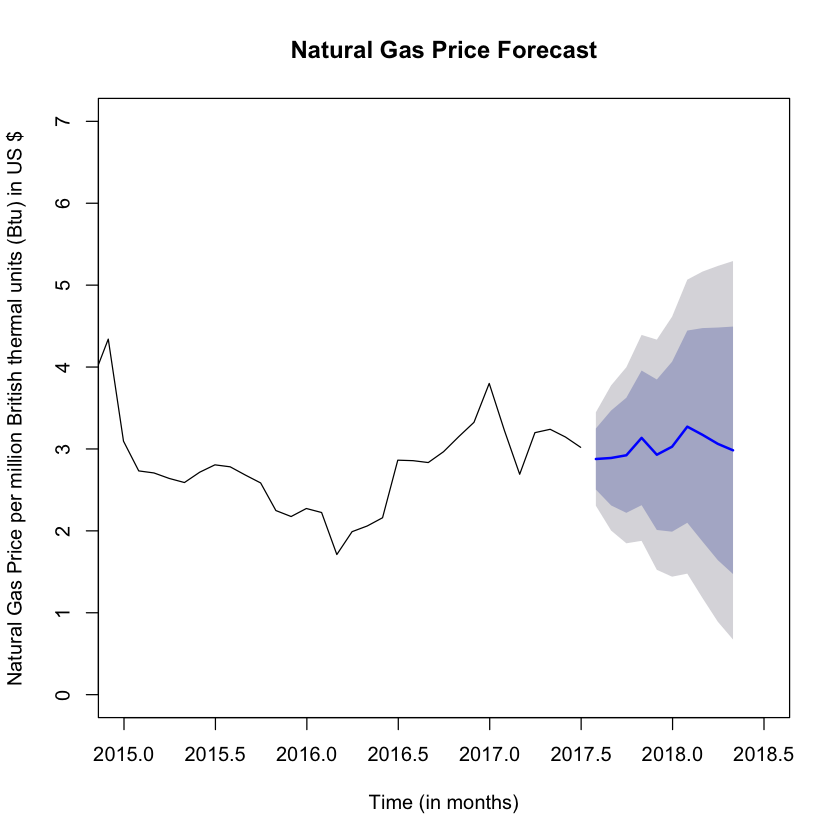

In [17]:
fcast_monthly <- forecast(fit_monthly, h=10)
plot(fcast_monthly,xlim = c(2015, 2018.5), ylim = c(0,7), xlab = "Time (in months)", 
     ylab = "Natural Gas Price per million British thermal units (Btu) in US $", 
    main = "Natural Gas Price Forecast")

In [18]:
fcast_monthly

         Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
2017.581       2.877217 2.504292 3.250142 2.3068771 3.447556
2017.664       2.889871 2.310580 3.469163 2.0039215 3.775821
2017.747       2.922894 2.220246 3.625543 1.8482858 3.997502
2017.831       3.135278 2.313369 3.957187 1.8782768 4.392279
2017.914       2.929473 2.010832 3.848114 1.5245323 4.334414
2017.997       3.027525 1.990023 4.065028 1.4408030 4.614248
2018.081       3.272225 2.098857 4.445592 1.4777139 5.066735
2018.164       3.172214 1.868845 4.475584 1.1788824 5.165546
2018.247       3.062636 1.642871 4.482402 0.8912920 5.233980
2018.331       2.983547 1.472893 4.494201 0.6732007 5.293892

# Exponential Smoothing

In [19]:
exp_model <- HoltWinters(monthly_ts)

exp_model

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = monthly_ts)

Smoothing parameters:
 alpha: 0.8846621
 beta : 0.02340981
 gamma: 1

Coefficients:
           [,1]
a    2.96921099
b   -0.03400946
s1   0.26947301
s2   0.27792924
s3   0.29448742
s4   0.44990706
s5   0.56805621
s6   0.18517432
s7  -0.16200283
s8  -0.35736625
s9  -0.31395254
s10 -0.40094184
s11 -0.36235326
s12  0.05078901

In [20]:
exp_pred <- predict(exp_model, 15, prediction.interval = TRUE)
exp_pred

fit,upr,lwr
3.204675,4.099415,2.3099345
3.179121,4.386091,1.9721512
3.161670,4.625691,1.6976487
3.283080,4.974527,1.5916337
3.367220,5.267315,1.4671246
2.950329,5.046076,0.8545812
2.569142,4.851041,0.2872428
2.339769,4.800616,-0.1210779
2.349173,4.983363,-0.2850167
2.228175,5.031265,-0.5749161


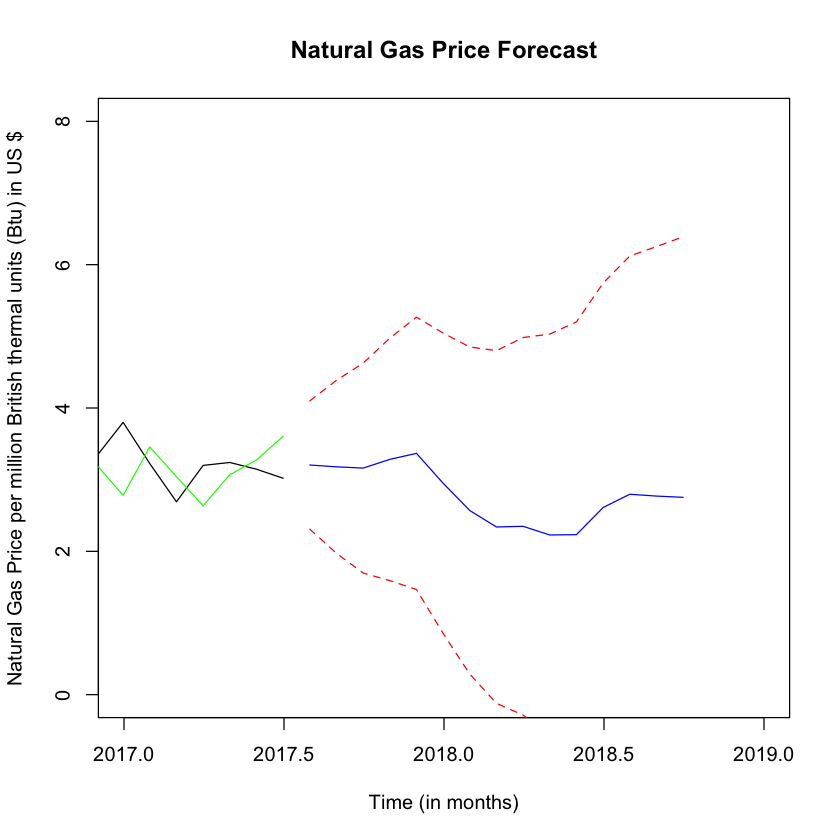

In [21]:
plot.ts(monthly_ts, xlim = c(2017, 2019), ylim = c(0,8), xlab = "Time (in months)", 
        ylab = "Natural Gas Price per million British thermal units (Btu) in US $",
       main = "Natural Gas Price Forecast")
lines(exp_model$fitted[,1], col = "green")
lines(exp_pred[,1], col = "blue")
lines(exp_pred[,2], col = "red", lty = 2)
lines(exp_pred[,3], col = "red", lty = 2)